In [ ]:
import numpy as np


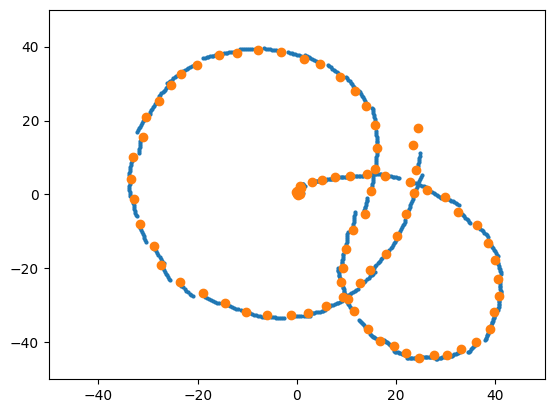

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from math import log

class EKFPositionEstimator:
    def __init__(self, dt, process_noise, measurement_noise):
        # Time step for accelerometer (50 Hz = 0.02s)
        self.dt = dt
        
        # Initial state [x, y, vx, vy]
        self.x = np.array([[0], [0], [0], [0]])
        
        # State transition matrix F
        self.F = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        
        # Control input matrix G
        self.G = np.array([
            [0.5 * dt**2, 0],
            [0, 0.5 * dt**2],
            [dt, 0],
            [0, dt]
        ])
        
        # Measurement matrix H
        self.H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        
        # Process noise covariance Q
        self.Q = process_noise * np.eye(4)
        
        # Measurement noise covariance R (based on GPS accuracy)
        self.R = measurement_noise * np.eye(4)
        
        # Initial estimate error covariance P
        self.P = np.eye(4)
    
    def predict(self, accel):
        """Prediction step of the EKF"""
        # Control input from accelerometer
        u = np.array([[accel[0]], [accel[1]]])
        
        # Predict the next state
        self.x = self.F @ self.x + self.G @ u
        
        # Predict the next covariance
        self.P = self.F @ self.P @ self.F.T + self.Q
        
    def update(self, gps_measurement, velocity_measurement):
        """Update step of the EKF with GPS measurement"""
        # GPS measurement as observation + velocity derived from GPS (m/s): { (x1, y1) - (x0, y0) / dt }
        z = np.array([[gps_measurement[0]], [gps_measurement[1]], [velocity_measurement[0]], [velocity_measurement[1]]]) # [x, y, vx, vy]
        
        # Calculate the Kalman Gain
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # Update the state estimate with the measurement
        y = z - (self.H @ self.x)  # Innovation (measurement residual)
        self.x = self.x + K @ y
        
        # Update the covariance matrix
        self.P = (np.eye(len(self.P)) - K @ self.H) @ self.P
    
    def get_state(self):
        return {
            'position': (self.x[0, 0], self.x[1, 0]),
            'velocity': (self.x[2, 0], self.x[3, 0])
        }
    
    def run(self, gps_data, velocity_data, accel_data):
        gps_index = 0
        predicted_vals = []
        for i in range(len(accel_data)):
            # Accelerometer refresh rate is 50 hz
            self.predict(accel_data[i])
            
            # GPS refresh rate is 5 hz
            if (i + 1) % 10 == 0:
                # Update step with GPS data if available
                if gps_index < len(gps_data):
                    self.update(gps_data[gps_index], velocity_data[gps_index])
                    gps_index += 1       

            # Print the estimated state
            state = self.get_state()
            predicted_vals.append(state['position'])
        return predicted_vals

file = open("gaussian_positions.txt", "r")
lineN = eval(file.read())
file.close()
file = open("positions.txt", "r")
lineReal = eval(file.read())
file.close()
file = open("accelerations.txt", "r")
accel = eval(file.read())
file.close()
file = open("velocity.txt", "r")
velocity = eval(file.read())
file.close()

# Fastest update rate is 50hz, so 1000ms / 50hz = 20ms or 0.02s
dt = 0.02
process_noise = 0.1
measurement_noise = 1 # GPS accuracy (1m)
ekf = EKFPositionEstimator(dt, process_noise, measurement_noise)
gps_data = lineN
accel_data = accel
predicted_line = ekf.run(gps_data, velocity, accel_data)

plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.scatter(*zip(*predicted_line), s=4)
plt.scatter(*zip(*lineN))
plt.show()